In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import MDAnalysis as mda
import prody as pd

# Load PDB files
parser = PDBParser()
structure1 = parser.get_structure('5uh5', '5uh5.pdb')
structure2 = parser.get_structure('6c04', '6c04.pdb')

#u1 = mda.Universe('5uh5.pdb', '5uh5.xtc')
#u2 = mda.Universe('6c04.pdb', '6c04.xtc')
# Load XTC files
trajectory1 = mda.Universe('5uh5.pdb', '5uh5.xtc')
trajectory2 = mda.Universe('6c04.pdb', '6c04.xtc')

# Align structures
ref_atoms1 = structure1[0]['A'].get_atoms()
mobile_atoms1 = structure2[0]['A'].get_atoms()
pd.calcTransformation(ref_atoms1, mobile_atoms1)

# Select alpha-carbon atoms
sel1 = "protein and chain A and name CA"
sel2 = "protein and chain B and name CA"
atoms1 = trajectory1.select_atoms(sel1)
atoms2 = trajectory2.select_atoms(sel2)

# Remove atoms not present in both structures
atoms1, atoms2 = mda.lib.distances.self_distance_array(atoms1.positions, atoms2.positions, box=trajectory1.dimensions)

# Create ANM models
anm1 = pd.proteins.anm.Anm('Protein 1')
anm1.buildHessian(atoms1)
anm2 = pd.proteins.anm.Anm('Protein 2')
anm2.buildHessian(atoms2)

# Calculate RMSF for each chain
chains1 = [chain for chain in structure1[0] if chain.id != ' ']
chains2 = [chain for chain in structure2[0] if chain.id != ' ']
for chain in chains1:
    selection = f"protein and chain {chain.id} and name CA"
    rmsf = pd.proteins.anm.calcRMSF(anm1, atoms1.select(selection))
    plt.plot(rmsf, label=f'Protein 1 Chain {chain.id}')
for chain in chains2:
    selection = f"protein and chain {chain.id} and name CA"
    rmsf = pd.proteins.anm.calcRMSF(anm2, atoms2.select(selection))
    plt.plot(rmsf, label=f'Protein 2 Chain {chain.id}')
plt.legend()
plt.show()


/home/sneha/.local/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 50725
  warnings.warn(
/home/sneha/.local/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 52499
  warnings.warn(


TypeError: mobile must be a numpy array or an object with getCoords method

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms, contacts
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis.anm import ANM, ANMAnalysis
import numpy as np
import matplotlib.pyplot as plt

# Load the PDB and XTC files
u1 = mda.Universe('5uh5.pdb', '5uh5.xtc')
u2 = mda.Universe('6c04.pdb', '6c04.xtc')

# Define the Elastic Network Model (ENM)
anm = ANM('CA')
anm.buildHessian(u1.select_atoms('name CA'))

# Calculate the anisotropic network model (ANM) normal modes
anm.calcModes()

# Calculate RMSF for each chain
chains1 = u1.select_atoms('protein').chains
chains2 = u2.select_atoms('protein').chains

rmsfs1 = []
rmsfs2 = []

for chain in chains1:
    chain_selection = 'protein and chain {}'.format(chain)
    ca_selection = chain_selection + ' and name CA'
    rmsf = ANMAnalysis(anm).calcRMSF(
        u1.select_atoms(ca_selection),
        zero=False,
        ref=None,
        verbose=True,
        mass=True
    )
    rmsfs1.append(rmsf)

for chain in chains2:
    chain_selection = 'protein and chain {}'.format(chain)
    ca_selection = chain_selection + ' and name CA'
    rmsf = ANMAnalysis(anm).calcRMSF(
        u2.select_atoms(ca_selection),
        zero=False,
        ref=None,
        verbose=True,
        mass=True
    )
    rmsfs2.append(rmsf)

# Plot the RMSF for each chain
fig, axs = plt.subplots(len(chains1)+len(chains2), figsize=(10,30))

i = 0
for rmsf in rmsfs1:
    axs[i].plot(rmsf, label='Chain {}'.format(chains1[i]))
    axs[i].set_title('RMSF for Chain {}'.format(chains1[i]))
    axs[i].set_xlabel('Residue')
    axs[i].set_ylabel('RMSF (Å)')
    i += 1

for rmsf in rmsfs2:
    axs[i].plot(rmsf, label='Chain {}'.format(chains2[i-len(chains1)]))
    axs[i].set_title('RMSF for Chain {}'.format(chains2[i-len(chains1)]))
    axs[i].set_xlabel('Residue')
    axs[i].set_ylabel('RMSF (Å)')
    i += 1

plt.tight_layout()
plt.show()


/home/sneha/.local/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


ModuleNotFoundError: No module named 'MDAnalysis.analysis.anm'

In [7]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# Load the PDB and XTC files
u1 = mda.Universe('5uh5.pdb', '5uh5.xtc')
u2 = mda.Universe('6c04.pdb', '6c04.xtc')

# Define a selection for the alpha carbon atoms
ca_selection = 'protein and name CA'

# Calculate the mean positions of the alpha carbon atoms
ca_positions1 = np.mean(u1.select_atoms(ca_selection).positions, axis=0)
ca_positions2 = np.mean(u2.select_atoms(ca_selection).positions, axis=0)

# Calculate the covariance matrix for the alpha carbon atoms
ca_covariance1 = np.cov(u1.select_atoms(ca_selection).positions.T)
ca_covariance2 = np.cov(u2.select_atoms(ca_selection).positions.T)

# Calculate the eigenvalues and eigenvectors of the covariance matrices
ca_eigenvalues1, ca_eigenvectors1 = np.linalg.eigh(ca_covariance1)
ca_eigenvalues2, ca_eigenvectors2 = np.linalg.eigh(ca_covariance2)

# Sort the eigenvalues and eigenvectors in descending order
ca_eigenvectors1 = ca_eigenvectors1[:, ::-1]
ca_eigenvectors2 = ca_eigenvectors2[:, ::-1]
ca_eigenvalues1 = ca_eigenvalues1[::-1]
ca_eigenvalues2 = ca_eigenvalues2[::-1]

# Calculate the normal modes as the product of the eigenvectors and square root of eigenvalues
anm1 = np.dot(ca_eigenvectors1, np.diag(np.sqrt(ca_eigenvalues1)))
anm2 = np.dot(ca_eigenvectors2, np.diag(np.sqrt(ca_eigenvalues2)))

# Calculate the RMSF for each chain
chains1 = u1.select_atoms('protein').segids
chains2 = u2.select_atoms('protein').segids

#for chain in chains1: print(chain)
len(chains1)

rmsfs1 = []
rmsfs2 = []

for chain in chains1:
    chain_selection = 'protein and chain {} and name CA'.format(chain)
    ca_positions = u1.select_atoms(chain_selection).positions - ca_positions1
    rmsf = np.sqrt(np.mean(np.sum((np.dot(ca_positions, anm1) ** 2), axis=1)))
    rmsfs1.append(rmsf)

for chain in chains2:
    chain_selection = 'protein and chain {} and name CA'.format(chain)
    ca_positions = u2.select_atoms(chain_selection).positions - ca_positions2
    rmsf = np.sqrt(np.mean(np.sum((np.dot(ca_positions, anm2) ** 2), axis=1)))
    rmsfs2.append(rmsf)


SelectionError: Unknown selection token: 'chain'

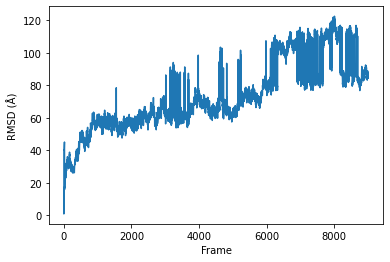

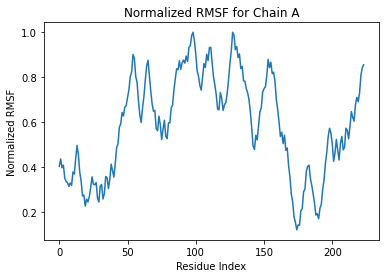

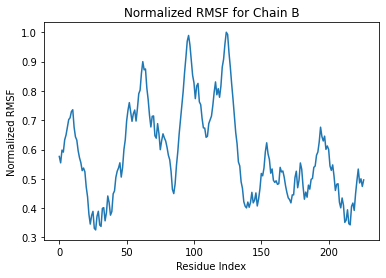

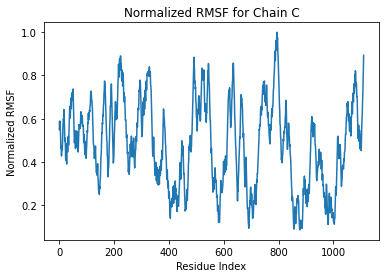

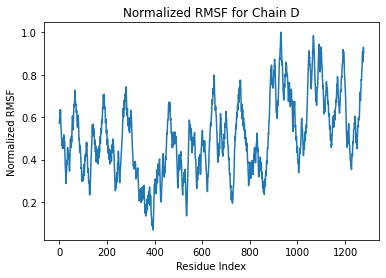

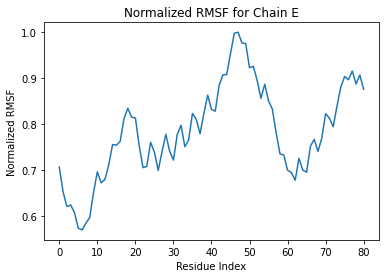

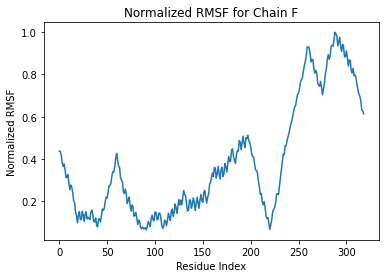

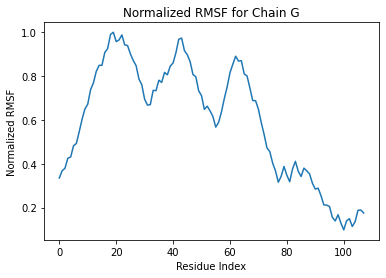

In [67]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# Load the PDB and XTC files
u_ref = mda.Universe('6c04.pdb')
u = mda.Universe('6c04.pdb', '6c04.xtc')

# Define a selection for the alpha carbon atoms
ca_selection = 'protein and name CA'

# Select the alpha carbon atoms from the reference structure
ca_ref = u_ref.select_atoms(ca_selection)

# Calculate the mean positions of the alpha carbon atoms in the reference structure
ca_positions_ref = np.mean(ca_ref.positions, axis=0)

# Calculate the covariance matrix for the alpha carbon atoms in the reference structure
ca_covariance_ref = np.cov(ca_ref.positions.T)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
ca_eigenvalues_ref, ca_eigenvectors_ref = np.linalg.eigh(ca_covariance_ref)

# Sort the eigenvalues and eigenvectors in descending order
ca_eigenvectors_ref = ca_eigenvectors_ref[:, ::-1]
ca_eigenvalues_ref = ca_eigenvalues_ref[::-1]

# Calculate the normal modes as the product of the eigenvectors and square root of eigenvalues
anm_ref = np.dot(ca_eigenvectors_ref, np.diag(np.sqrt(ca_eigenvalues_ref)))

# Define an empty array to store the RMSD values
rmsds = []

# Iterate over all frames in the trajectory
for ts in u.trajectory:

    # Select the alpha carbon atoms in the current frame
    ca = u.select_atoms(ca_selection)

    # Calculate the mean positions of the alpha carbon atoms in the current frame
    ca_positions = np.mean(ca.positions, axis=0)

    # Calculate the covariance matrix for the alpha carbon atoms in the current frame
    ca_covariance = np.cov(ca.positions.T)

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    ca_eigenvalues, ca_eigenvectors = np.linalg.eigh(ca_covariance)

    # Sort the eigenvalues and eigenvectors in descending order
    ca_eigenvectors = ca_eigenvectors[:, ::-1]
    ca_eigenvalues = ca_eigenvalues[::-1]

    # Calculate the normal modes as the product of the eigenvectors and square root of eigenvalues
    anm = np.dot(ca_eigenvectors, np.diag(np.sqrt(ca_eigenvalues)))

    # Calculate the transformation matrix from the reference structure to the current frame using the Kabsch algorithm
    transform, _ = mda.analysis.align.alignto(ca_ref, ca, weights=ca.masses)

    # Transform the reference normal modes to the current frame using the transformation matrix
    anm_transformed = np.dot(anm_ref, transform)

    # Calculate the RMSD between the transformed reference normal modes and the normal modes of the current frame
    rmsd = np.sqrt(np.mean((anm_transformed - anm) ** 2))
    
    # Append the RMSD value to the array
    rmsds.append(rmsd)


# Plot the RMSD values over time
plt.plot(np.arange(len(rmsds)), rmsds)
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.savefig('RMSD_6C04.png',dpi = 600)
plt.show()

import matplotlib.pyplot as plt

# Initialize an empty list to store normalized RMSF values for each chain
normalized_rmsfs = []

# Loop over all chains and calculate the RMSF for C-alpha atoms
chains = np.unique([a.segid for a in u.atoms if a.name == 'CA'])
for chain in chains:
    chain_selection = f"protein and segid {chain} and name CA"
    ca_positions_ref = u_ref.select_atoms(chain_selection).positions
    ca_positions_new = u.select_atoms(chain_selection).positions

    # Calculate the RMSF for each C-alpha atom in the chain
    rmsfs = np.sqrt(np.mean((ca_positions_new - ca_positions_ref) ** 2, axis=1))
    
    # Normalize the RMSF by dividing by the maximum RMSF value for the chain
    normalized_rmsf = rmsfs / np.max(rmsfs)
    normalized_rmsfs.append(normalized_rmsf)

# Plot the normalized RMSF values for each chain in separate graphs
for chain, normalized_rmsf in zip(chains, normalized_rmsfs):
    plt.figure()
    plt.plot(normalized_rmsf)
    plt.xlabel('Residue Index')
    plt.ylabel('Normalized RMSF')
    plt.title(f'Normalized RMSF for Chain {chain}')
    plt.savefig(chain+'_RMSf_6C04.png',dpi = 600)
    plt.show()

Average RMSF: 692.180 Å


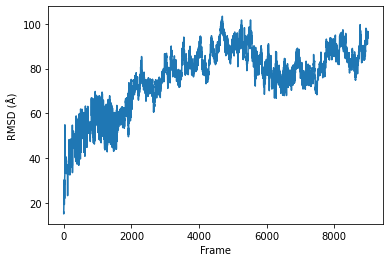

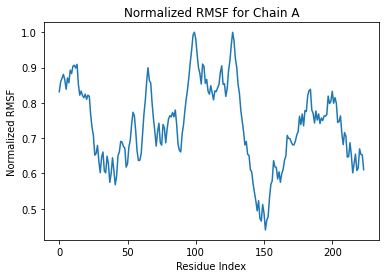

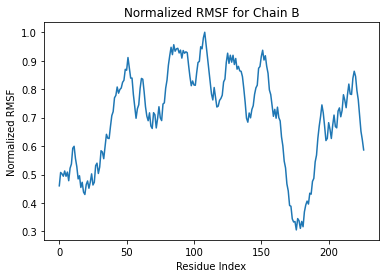

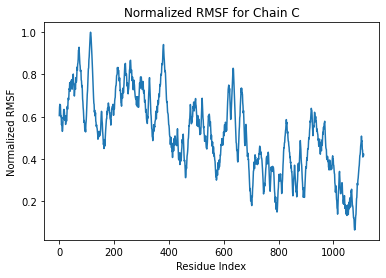

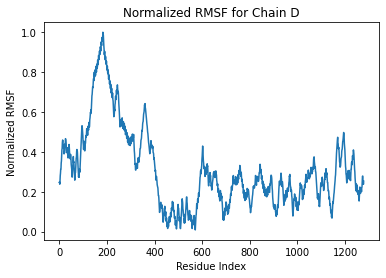

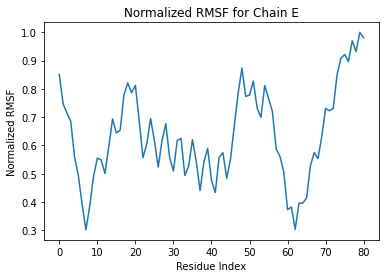

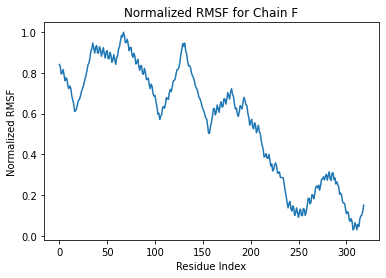

In [59]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# Load the PDB and XTC files
u_ref = mda.Universe('5uh5.pdb')
u = mda.Universe('5uh5.pdb', '5uh5.xtc')

# Define a selection for the alpha carbon atoms
ca_selection = 'protein and name CA'

# Select the alpha carbon atoms from the reference structure
ca_ref = u_ref.select_atoms(ca_selection)

# Calculate the mean positions of the alpha carbon atoms in the reference structure
ca_positions_ref = np.mean(ca_ref.positions, axis=0)

# Calculate the covariance matrix for the alpha carbon atoms in the reference structure
ca_covariance_ref = np.cov(ca_ref.positions.T)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
ca_eigenvalues_ref, ca_eigenvectors_ref = np.linalg.eigh(ca_covariance_ref)

# Sort the eigenvalues and eigenvectors in descending order
ca_eigenvectors_ref = ca_eigenvectors_ref[:, ::-1]
ca_eigenvalues_ref = ca_eigenvalues_ref[::-1]

# Calculate the normal modes as the product of the eigenvectors and square root of eigenvalues
anm_ref = np.dot(ca_eigenvectors_ref, np.diag(np.sqrt(ca_eigenvalues_ref)))

# Define an empty array to store the RMSD values
rmsds = []

# Iterate over all frames in the trajectory
for ts in u.trajectory:

    # Select the alpha carbon atoms in the current frame
    ca = u.select_atoms(ca_selection)

    # Calculate the mean positions of the alpha carbon atoms in the current frame
    ca_positions = np.mean(ca.positions, axis=0)

    # Calculate the covariance matrix for the alpha carbon atoms in the current frame
    ca_covariance = np.cov(ca.positions.T)

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    ca_eigenvalues, ca_eigenvectors = np.linalg.eigh(ca_covariance)

    # Sort the eigenvalues and eigenvectors in descending order
    ca_eigenvectors = ca_eigenvectors[:, ::-1]
    ca_eigenvalues = ca_eigenvalues[::-1]

    # Calculate the normal modes as the product of the eigenvectors and square root of eigenvalues
    anm = np.dot(ca_eigenvectors, np.diag(np.sqrt(ca_eigenvalues)))

    # Calculate the transformation matrix from the reference structure to the current frame using the Kabsch algorithm
    transform, _ = mda.analysis.align.alignto(ca_ref, ca, weights=ca.masses)

    # Transform the reference normal modes to the current frame using the transformation matrix
    anm_transformed = np.dot(anm_ref, transform)

    # Calculate the RMSD between the transformed reference normal modes and the normal modes of the current frame
    rmsd = np.sqrt(np.mean((anm_transformed - anm) ** 2))
    
    # Append the RMSD value to the array
    rmsds.append(rmsd)


# Plot the RMSD values over time
plt.plot(np.arange(len(rmsds)), rmsds)
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')

plt.savefig('5uh5_rmsd.png',dpi = 300)
plt.show()

import matplotlib.pyplot as plt

# Initialize an empty list to store normalized RMSF values for each chain
normalized_rmsfs = []

# Loop over all chains and calculate the RMSF for C-alpha atoms
chains = np.unique([a.segid for a in u.atoms if a.name == 'CA'])
for chain in chains:
    chain_selection = f"protein and segid {chain} and name CA"
    ca_positions_ref = u_ref.select_atoms(chain_selection).positions
    ca_positions_new = u.select_atoms(chain_selection).positions

    # Calculate the RMSF for each C-alpha atom in the chain
    rmsfs = np.sqrt(np.mean((ca_positions_new - ca_positions_ref) ** 2, axis=1))
    
    # Normalize the RMSF by dividing by the maximum RMSF value for the chain
    normalized_rmsf = rmsfs / np.max(rmsfs)
    normalized_rmsfs.append(normalized_rmsf)

# Plot the normalized RMSF values for each chain in separate graphs
for chain, normalized_rmsf in zip(chains, normalized_rmsfs):
    plt.figure()
    plt.plot(normalized_rmsf)
    plt.xlabel('Residue Index')
    plt.ylabel('Normalized RMSF')
    plt.title(f'Normalized RMSF for Chain {chain}')
    plt.show()

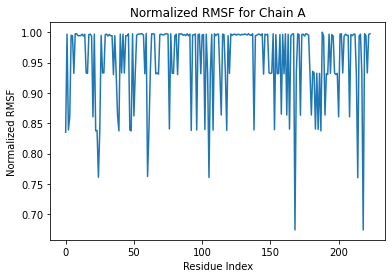

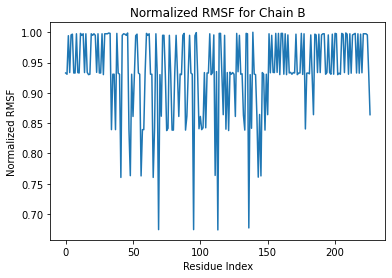

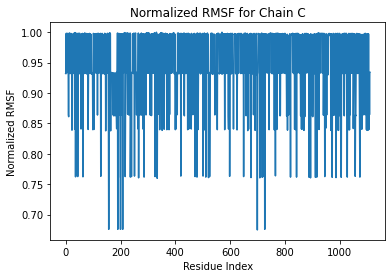

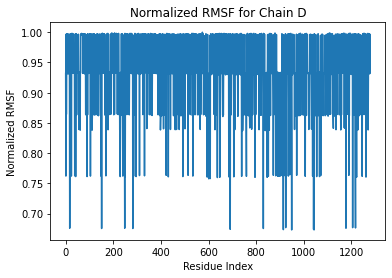

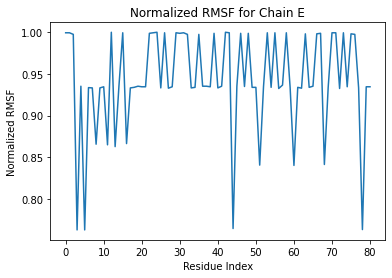

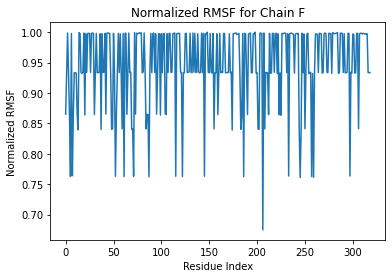

In [56]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# Load the PDB and XTC files
u_ref_5uh5 = mda.Universe('5uh5.pdb')
u_5uh5 = mda.Universe('5uh5.pdb', '5uh5.xtc')

u_ref_6c04 = mda.Universe('6c04.pdb')
u_6c04 = mda.Universe('6c04.pdb', '6c04.xtc')

# Define a selection for the alpha carbon atoms
ca_selection = 'protein and name CA'

# Select the alpha carbon atoms from the reference structure
ca_ref_5uh5 = u_ref_5uh5.select_atoms(ca_selection)
ca_ref_6c04 = u_ref_6c04.select_atoms(ca_selection)

# Calculate the mean positions of the alpha carbon atoms in the reference structure
ca_positions_ref_5uh5 = np.mean(ca_ref_5uh5.positions, axis=0)
ca_positions_ref_6c04 = np.mean(ca_ref_6c04.positions, axis=0)

# Calculate the covariance matrix for the alpha carbon atoms in the reference structure
ca_covariance_ref_5uh5 = np.cov(ca_ref_5uh5.positions.T)
ca_covariance_ref_6c04 = np.cov(ca_ref_6c04.positions.T)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
ca_eigenvalues_ref_5uh5, ca_eigenvectors_ref_5uh5 = np.linalg.eigh(ca_covariance_ref_5uh5)
ca_eigenvalues_ref_6c04, ca_eigenvectors_ref_6c04 = np.linalg.eigh(ca_covariance_ref_6c04)

# Sort the eigenvalues and eigenvectors in descending order
ca_eigenvectors_ref_5uh5 = ca_eigenvectors_ref_5uh5[:, ::-1]
ca_eigenvalues_ref_5uh5 = ca_eigenvalues_ref_5uh5[::-1]

ca_eigenvectors_ref_6c04 = ca_eigenvectors_ref_6c04[:, ::-1]
ca_eigenvalues_ref_6c04 = ca_eigenvalues_ref_6c04[::-1]
'''
# Calculate the normal modes as the product of the eigenvectors and square root of eigenvalues
anm_ref_5uh5 = np.dot(ca_eigenvectors_ref_5uh5, np.diag(np.sqrt(ca_eigenvalues_ref_5uh5)))
anm_ref_6c04 = np.dot(ca_eigenvectors_ref_6c04, np.diag(np.sqrt(ca_eigenvalues_ref_6c04)))

# Define an empty array to store the RMSD values
rmsds = []

# Iterate over all frames in the trajectory
for ts in u.trajectory:

    # Select the alpha carbon atoms in the current frame
    ca = u.select_atoms(ca_selection)

    # Calculate the mean positions of the alpha carbon atoms in the current frame
    ca_positions = np.mean(ca.positions, axis=0)

    # Calculate the covariance matrix for the alpha carbon atoms in the current frame
    ca_covariance = np.cov(ca.positions.T)

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    ca_eigenvalues, ca_eigenvectors = np.linalg.eigh(ca_covariance)

    # Sort the eigenvalues and eigenvectors in descending order
    ca_eigenvectors = ca_eigenvectors[:, ::-1]
    ca_eigenvalues = ca_eigenvalues[::-1]

    # Calculate the normal modes as the product of the eigenvectors and square root of eigenvalues
    anm = np.dot(ca_eigenvectors, np.diag(np.sqrt(ca_eigenvalues)))

    # Calculate the transformation matrix from the reference structure to the current frame using the Kabsch algorithm
    transform, _ = mda.analysis.align.alignto(ca_ref, ca, weights=ca.masses)

    # Transform the reference normal modes to the current frame using the transformation matrix
    anm_transformed = np.dot(anm_ref, transform)

    # Calculate the RMSD between the transformed reference normal modes and the normal modes of the current frame
    rmsd = np.sqrt(np.mean((anm_transformed - anm) ** 2))
    
    # Append the RMSD value to the array
    rmsds.append(rmsd)


# Plot the RMSD values over time
plt.plot(np.arange(len(rmsds)), rmsds)
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.savefig('5uh5_rmsd.png',dpi = 300)
plt.show()
'''
import matplotlib.pyplot as plt

# Initialize an empty list to store normalized RMSF values for each chain
normalized_rmsfs_5uh5 = []
normalized_rmsfs_6c04 = []

# Loop over all chains and calculate the RMSF for C-alpha atoms
chains_5uh5 = np.unique([a.segid for a in u_5uh5.atoms if a.name == 'CA'])
chains_6c04 = np.unique([a.segid for a in u_6c04.atoms if a.name == 'CA'])

for chain in chains_5uh5:
    chain_selection = f"protein and segid {chain} and name CA"
    ca_positions_ref_5uh5 = u_ref_5uh5.select_atoms(chain_selection).positions
    ca_positions_new_5uh5 = u_5uh5.select_atoms(chain_selection).positions

    # Calculate the RMSF for each C-alpha atom in the chain
    rmsfs_5uh5 = np.sqrt(np.mean((ca_positions_new_5uh5 - ca_positions_ref_5uh5) ** 2, axis=1))
    
    # Normalize the RMSF by dividing by the maximum RMSF value for the chain
    normalized_rmsf_5uh5 = rmsfs_5uh5 / np.max(rmsfs_5uh5)
    normalized_rmsfs_5uh5.append(normalized_rmsf_5uh5)

# Plot the normalized RMSF values for each chain in separate graphs
for chain, normalized_rmsf_5uh5 in zip(chains, normalized_rmsfs_5uh5):
    plt.figure()
    plt.plot(normalized_rmsf_5uh5)
    plt.xlabel('Residue Index')
    plt.ylabel('Normalized RMSF')
    plt.title(f'Normalized RMSF for Chain {chain}')
    plt.show()




In [65]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# Load the reference structure and trajectory
u_ref = mda.Universe('5uh5.pdb')
u = mda.Universe('5uh5.pdb', '5uh5.xtc')

# Define a selection for the alpha carbon atoms
ca_selection = 'protein and name CA'

# Select the alpha carbon atoms from the reference structure
ca_ref = u_ref.select_atoms(ca_selection)

# Define an empty array to store the RMSD values
rmsds = []

# Iterate over all frames in the trajectory
for ts in u.trajectory:

    # Select the alpha carbon atoms in the current frame
    ca = u.select_atoms(ca_selection)

    # Calculate the mean positions of the alpha carbon atoms in the current frame
    ca_positions = np.mean(ca.positions, axis=0)

    # Calculate the covariance matrix for the alpha carbon atoms in the current frame
    ca_covariance = np.cov(ca.positions.T)

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    ca_eigenvalues, ca_eigenvectors = np.linalg.eigh(ca_covariance)

    # Sort the eigenvalues and eigenvectors in descending order
    ca_eigenvectors = ca_eigenvectors[:, ::-1]
    ca_eigenvalues = ca_eigenvalues[::-1]

    # Calculate the transformation matrix from the reference structure to the current frame using the Kabsch algorithm
    transform = mda.analysis.align.rotation_matrix(ca_ref.positions, ca.positions, weights=ca.masses)

    # Transform the reference alpha carbon positions to the current frame using the transformation matrix
    ca_positions_ref_transformed = ca_ref.positions @ transform

    # Calculate the RMSD between the transformed reference alpha carbon positions and the alpha carbon positions of the current frame
    rmsd = np.sqrt(np.mean((ca_positions_ref_transformed - ca_positions) ** 2))

    # Append the RMSD value to the array
    rmsds.append(rmsd)

# Plot the RMSD values over time
plt.plot(np.arange(len(rmsds)), rmsds)
plt.xlabel('Frame')
plt.ylabel('RMSD (Å)')
plt.savefig('rmsd.png', dpi=300)
plt.show()




/tmp/ipykernel_136626/4137830886.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ca_positions_ref_transformed = ca_ref.positions @ transform


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

In [69]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

def calculate_perturbation_response(pdb_file, xtc_file):
    traj = md.load(xtc_file, top=pdb_file)
    traj_ca = traj.atom_slice(traj.topology.select('name CA'))

    num_residues = traj_ca.n_residues
    prs_matrix = np.zeros((num_residues, num_residues))

    for i in range(num_residues):
        for j in range(num_residues):
            if i != j:
                atom_i = traj_ca.topology.select(f'residue {i}')
                atom_j = traj_ca.topology.select(f'residue {j}')
                distances = md.compute_distances(traj_ca, [atom_i, atom_j])
                prs_matrix[i, j] = np.mean(distances)

    return prs_matrix

def plot_heatmap(matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='hot', origin='lower')
    plt.colorbar(label='Perturbation Response')
    plt.title(title)
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.tight_layout()
    plt.show()

pdb_file = '5uh5.pdb'
xtc_file = '5uh5.xtc'

# Calculate the perturbation response scanning matrix
prs_matrix = calculate_perturbation_response(pdb_file, xtc_file)

# Plot the heatmap
plot_heatmap(prs_matrix, 'Perturbation Response Scanning')



: 

: 